In [1]:
import warnings
warnings.filterwarnings('ignore')

In [2]:
import matplotlib.pyplot as plt
import pandas as pd
import torch
from torchtext.data import Field, TabularDataset, BucketIterator, Iterator
import torch.nn as nn
from transformers import BertTokenizer, BertForSequenceClassification
import torch.optim as optim
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
import seaborn as sns
from tqdm.notebook import tqdm
from transformers import AutoConfig, AutoModelForSequenceClassification, AutoTokenizer, EvalPrediction

In [3]:
!CUDA_VISIBLE_DEVICES=0

In [4]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
device

device(type='cuda')

In [5]:
torch.cuda.set_device(0)

In [ ]:
def count_tokens(x):
    return len(x.split())

In [ ]:
# max min mean 
df = pd.read_csv('data/train.csv')
df['tokens'] = df.text.map(lambda x: count_tokens(x))
df.tokens.agg(["max","min","mean"])

In [76]:
tokenizer = BertTokenizer.from_pretrained('bert-base-uncased')

# Model parameter
MAX_SEQ_LEN = 128
PAD_INDEX = tokenizer.convert_tokens_to_ids(tokenizer.pad_token)
UNK_INDEX = tokenizer.convert_tokens_to_ids(tokenizer.unk_token)
source_folder = 'data'

label_field = Field(sequential=False, use_vocab=False, batch_first=True, dtype=torch.float)
text_field = Field(use_vocab=False, tokenize=tokenizer.encode, lower=False, include_lengths=False, batch_first=True,
                   fix_length=MAX_SEQ_LEN, pad_token=PAD_INDEX, unk_token=UNK_INDEX)
fields = [('text', text_field), ('label', label_field)]

# TabularDataset

train, valid, test = TabularDataset.splits(path=source_folder, train='train_mixed.csv', validation='valid.csv',
                                           test='test_mixed.csv', format='CSV', fields=fields, skip_header=True)

# Iterators

train_iter = BucketIterator(train, batch_size=32, sort_key=lambda x: len(x.text),
                            device=device, train=True, sort=True, sort_within_batch=True)
valid_iter = BucketIterator(valid, batch_size=32, sort_key=lambda x: len(x.text),
                            device=device, train=True, sort=True, sort_within_batch=True)
test_iter = Iterator(test, batch_size=32, device=device, train=False, shuffle=False, sort=False)

In [8]:
class BERT(nn.Module):

    def __init__(self):
        super(BERT, self).__init__()

        options_name = "bert-base-uncased"
        self.bert = BertForSequenceClassification.from_pretrained(options_name)

    def forward(self, text, label):
        loss, text_fea = self.bert(text, labels=label)[:2]

        return loss, text_fea

In [9]:
# Save and Load Functions

def save_checkpoint(save_path, model, valid_loss):

    if save_path == None:
        return
    
    state_dict = {'model_state_dict': model.state_dict(),
                  'valid_loss': valid_loss}
    
    torch.save(state_dict, save_path)
    print(f'Model saved to ==> {save_path}')

def load_checkpoint(load_path, model):
    
    if load_path==None:
        return
    
    state_dict = torch.load(load_path, map_location=device)
    print(f'Model loaded from <== {load_path}')
    
    model.load_state_dict(state_dict['model_state_dict'])
    return state_dict['valid_loss']


def save_metrics(save_path, train_loss_list, valid_loss_list, global_steps_list):

    if save_path == None:
        return
    
    state_dict = {'train_loss_list': train_loss_list,
                  'valid_loss_list': valid_loss_list,
                  'global_steps_list': global_steps_list}
    
    torch.save(state_dict, save_path)
    print(f'Model saved to ==> {save_path}')


def load_metrics(load_path):

    if load_path==None:
        return
    
    state_dict = torch.load(load_path, map_location=device)
    print(f'Model loaded from <== {load_path}')
    
    return state_dict['train_loss_list'], state_dict['valid_loss_list'], state_dict['global_steps_list']

In [34]:

# Training Function
destination_folder = 'output_mixed_new'
def train(model,
          optimizer,
          criterion = nn.BCELoss(),
          train_loader = train_iter,
          valid_loader = valid_iter,
          num_epochs = 1,
          eval_every = len(train_iter) // 2,
          file_path = destination_folder,
          best_valid_loss = float("Inf")):
    
    # initialize running values
    running_loss = 0.0
    valid_running_loss = 0.0
    global_step = 0
    train_loss_list = []
    valid_loss_list = []
    global_steps_list = []

    # training loop
    model.train()
    for epoch in tqdm(range(num_epochs), desc='epochs'):
        for (text, labels), _ in tqdm(train_loader, desc='training examples'):
            labels = labels.type(torch.LongTensor)           
            labels = labels.to(device)
            text = text.type(torch.LongTensor)  
            text = text.to(device)
            output = model(text, labels)
            loss, _ = output

            optimizer.zero_grad()
            loss.backward()
            optimizer.step()

            # update running values
            running_loss += loss.item()
            global_step += 1

            # evaluation step
            if global_step % eval_every == 0:
                model.eval()
                with torch.no_grad():                    

                    # validation loop
                    for (text, labels), _ in valid_loader:
                        labels = labels.type(torch.LongTensor)           
                        labels = labels.to(device)
                        text = text.type(torch.LongTensor)  
                        text = text.to(device)
                        output = model(text, labels)
                        loss, _ = output
                        
                        valid_running_loss += loss.item()

                # evaluation
                average_train_loss = running_loss / eval_every
                average_valid_loss = valid_running_loss / len(valid_loader)
                train_loss_list.append(average_train_loss)
                valid_loss_list.append(average_valid_loss)
                global_steps_list.append(global_step)

                # resetting running values
                running_loss = 0.0                
                valid_running_loss = 0.0
                model.train()

                # print progress
                print('Epoch [{}/{}], Step [{}/{}], Train Loss: {:.4f}, Valid Loss: {:.4f}'
                      .format(epoch+1, num_epochs, global_step, num_epochs*len(train_loader),
                              average_train_loss, average_valid_loss))
                
                # checkpoint
                if best_valid_loss > average_valid_loss:
                    best_valid_loss = average_valid_loss
                    save_checkpoint(file_path + '/' + 'model.pt', model, best_valid_loss)
                    save_metrics(file_path + '/' + 'metrics.pt', train_loss_list, valid_loss_list, global_steps_list)
    
    save_metrics(file_path + '/' + 'metrics.pt', train_loss_list, valid_loss_list, global_steps_list)
    print('Finished Training!')

model = BERT().to(device)
optimizer = optim.Adam(model.parameters(), lr=2e-5)

train(model=model, optimizer=optimizer)

Some weights of the model checkpoint at bert-base-uncased were not used when initializing BertForSequenceClassification: ['cls.predictions.bias', 'cls.predictions.transform.dense.weight', 'cls.predictions.transform.dense.bias', 'cls.predictions.decoder.weight', 'cls.seq_relationship.weight', 'cls.seq_relationship.bias', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.transform.LayerNorm.bias']
- This IS expected if you are initializing BertForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPretraining model).
- This IS NOT expected if you are initializing BertForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at

Epoch [1/1], Step [129/258], Train Loss: 0.4090, Valid Loss: 0.1445
Model saved to ==> output_mixed_new/model.pt
Model saved to ==> output_mixed_new/metrics.pt
Epoch [1/1], Step [258/258], Train Loss: 0.1103, Valid Loss: 0.0957
Model saved to ==> output_mixed_new/model.pt
Model saved to ==> output_mixed_new/metrics.pt


Model saved to ==> output_mixed_new/metrics.pt
Finished Training!


Model loaded from <== output_mixed_new/metrics.pt


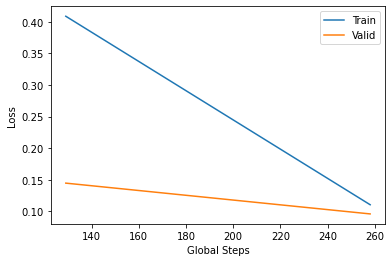

In [35]:
destination_folder = 'output_mixed_new'
train_loss_list, valid_loss_list, global_steps_list = load_metrics(destination_folder + '/metrics.pt')
plt.plot(global_steps_list, train_loss_list, label='Train')
plt.plot(global_steps_list, valid_loss_list, label='Valid')
plt.xlabel('Global Steps')
plt.ylabel('Loss')
plt.legend()
plt.show() 

In [13]:

def evaluate(model, test_loader):
    y_pred = []
    y_true = []
    x_text = []

    model.eval()
    with torch.no_grad():
        for (text, labels), _ in tqdm(test_loader, desc='Testing examples'):
                labels = labels.type(torch.LongTensor)           
                labels = labels.to(device)
                text = text.type(torch.LongTensor)  
                text = text.to(device)
                output = model(text, labels)

                _, output = output
                x_text.extend(text.tolist())
                y_pred.extend(torch.argmax(output, 1).tolist())
                y_true.extend(labels.tolist())
    
    print('Classification Report:')
    print(classification_report(y_true, y_pred, labels=[1,0], digits=4))
    
    cm = confusion_matrix(y_true, y_pred, labels=[1,0])
    ax= plt.subplot()
    sns.heatmap(cm, annot=True, ax = ax, cmap='Blues', fmt="d")

    ax.set_title('Confusion Matrix')

    ax.set_xlabel('Predicted Labels')
    ax.set_ylabel('True Labels')

    ax.xaxis.set_ticklabels(['1', '0'])
    ax.yaxis.set_ticklabels(['1', '0'])
    plt.show()
    return x_text, y_pred, y_true


Classification Report:
              precision    recall  f1-score   support

           1     0.8055    0.9601    0.8760       552
           0     0.9507    0.7681    0.8497       552

    accuracy                         0.8641      1104
   macro avg     0.8781    0.8641    0.8629      1104
weighted avg     0.8781    0.8641    0.8629      1104



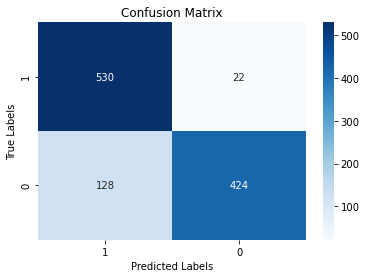

In [78]:
destination_folder = 'output_mixed_new'
#best_model = BERT().to(device)

#load_checkpoint(destination_folder + '/model.pt', best_model)
x_text, y_pred, y_true = evaluate(model, test_iter)

In [58]:
def convert_ids_to_sentence(seq,tokenizer):
    idx = seq.index(102)
    seq = seq[1:idx]
    return tokenizer.decode(seq)

In [38]:
df = pd.DataFrame(zip(x_text,y_pred,y_true), columns=['text', 'y_pred', 'y_true'])
df = df[(df['y_pred'] == 0) & (df['y_true'] == 1)]
df['sentence'] = df.text.map(lambda x: convert_ids_to_sentence(x, tokenizer))

In [39]:
df

,text,y_pred,y_true,sentence
22,"[101, 4067, 2017, 1010, 9119, 999, 102, 0, 0, ...",0,1,"thank you, goodbye!"
27,"[101, 2073, 2024, 2017, 2975, 2013, 1029, 102,...",0,1,where are you leaving from?
54,"[101, 1996, 5700, 3345, 3727, 2012, 2459, 1024...",0,1,the earliest train leaves at 17 : 00
114,"[101, 4067, 2017, 1010, 9119, 999, 102, 0, 0, ...",0,1,"thank you, goodbye!"
135,"[101, 1045, 102, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,...",0,1,i
...,...,...,...,...
7246,"[101, 19817, 2620, 2683, 16703, 3727, 2012, 23...",0,1,tr8932 leaves at 15 : 11
7254,"[101, 9660, 2406, 2380, 9660, 2346, 9660, 2406...",0,1,milton country park milton road milton country...
7260,"[101, 2045, 2003, 1037, 5988, 1010, 1037, 2688...",0,1,"there is a cinema, a museum, a theatre, a park..."
7266,"[101, 1045, 102, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,...",0,1,i


In [40]:
for elem in df.sentence:
    print(elem + '\n')

thank you, goodbye!

where are you leaving from?

the earliest train leaves at 17 : 00

thank you, goodbye!

i

thank you, goodbye!

the phone numbe

i

the phone numbe

tr8944 will get you in by 15 : 39.

it is expensive

the address i

tr5713 is the train id.

thank you, goodbye!

the departure time is 5 : 40

thank you, goodbye!

tr9226 arrives by 17 : 58

tr7802 would work for you, would you like me to book it?

tr8118 leaves at 19 : 21

tr1719 arrives at 10 : 09.

i have tw

tr2162 leaves at 14 : 11.

thank you, goodbye!

it is 49 minutes

the address i

it is a hotel

191 histon road chesterton

when do you want to leave by?

i have

where are you leaving from?

i would recommend allenbell

it is 5 pounds to get in

the address i

the address i

the address fo

yes it will pick you up

tr3677 arrives by 17 : 58.

tr9102 is the train id, would you like me to book it for you?

the soul tree nightclub is 4 pounds to get in.

tr5297 would work for you. would you like me to book it fo

# SC-GPT evaluation

In [8]:
# Load SC-GPT Results to evaluate coherence
tokenizer = BertTokenizer.from_pretrained('bert-base-uncased')
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
# Model parameter
MAX_SEQ_LEN = 128
PAD_INDEX = tokenizer.convert_tokens_to_ids(tokenizer.pad_token)
UNK_INDEX = tokenizer.convert_tokens_to_ids(tokenizer.unk_token)
source_folder = 'sc_gpt'

label_field = Field(sequential=False, use_vocab=False, batch_first=True, dtype=torch.float)
text_field = Field(use_vocab=False, tokenize=tokenizer.encode, lower=False, include_lengths=False, batch_first=True,
                   fix_length=MAX_SEQ_LEN, pad_token=PAD_INDEX, unk_token=UNK_INDEX)
fields = [('text', text_field), ('label', label_field)]

# TabularDataset

test = TabularDataset.splits(path=source_folder, test='mw_sc_gpt_mixed.csv', format='CSV', fields=fields, skip_header=True)

# Iterators

test_iter = Iterator(test[0], batch_size=64, device=device, train=False, shuffle=False, sort=False)

/opt/conda/lib/python3.7/site-packages/torchtext/data/iterator.py:48: UserWarning: Iterator class will be retired in the 0.8.0 release and moved to torchtext.legacy. Please see 0.7.0 release notes for further information.
  warnings.warn('{} class will be retired in the 0.8.0 release and moved to torchtext.legacy. Please see 0.7.0 release notes for further information.'.format(self.__class__.__name__), UserWarning)


Some weights of the model checkpoint at bert-base-uncased were not used when initializing BertForSequenceClassification: ['cls.predictions.bias', 'cls.predictions.transform.dense.weight', 'cls.predictions.transform.dense.bias', 'cls.predictions.decoder.weight', 'cls.seq_relationship.weight', 'cls.seq_relationship.bias', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.transform.LayerNorm.bias']
- This IS expected if you are initializing BertForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPretraining model).
- This IS NOT expected if you are initializing BertForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at

Model loaded from <== bert_gpt_lm_new/model.pt


/opt/conda/lib/python3.7/site-packages/torchtext/data/batch.py:23: UserWarning: Batch class will be retired in the 0.8.0 release and moved to torchtext.legacy. Please see 0.7.0 release notes for further information.
  warnings.warn('{} class will be retired in the 0.8.0 release and moved to torchtext.legacy. Please see 0.7.0 release notes for further information.'.format(self.__class__.__name__), UserWarning)



Classification Report:
              precision    recall  f1-score   support

           1     0.5015    0.9535    0.6573      7372
           0     0.5288    0.0522    0.0951      7372

    accuracy                         0.5028     14744
   macro avg     0.5152    0.5028    0.3762     14744
weighted avg     0.5152    0.5028    0.3762     14744



[Text(0, 0.5, '1'), Text(0, 1.5, '0')]

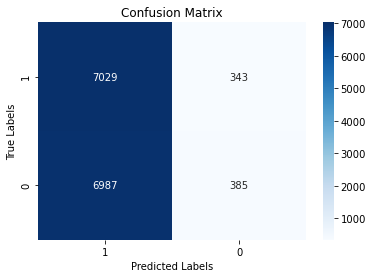

In [10]:
destination_folder = 'bert_gpt_lm_new'
#load model and send it to the GPU
#device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = BERT().to(device)

#load the checkpoint
load_checkpoint(destination_folder + '/model.pt', model)

#evaluate
y_pred = []
y_true = []
x_text = []
model.eval()
with torch.no_grad():
    for (text, labels), _ in tqdm(test_iter, desc='Testing examples'):
            labels = labels.type(torch.LongTensor)           
            labels = labels.to(device)
            text = text.type(torch.LongTensor)  
            text = text.to(device)
            output = model(text, labels)

            _, output = output
            x_text.extend(text.tolist())
            y_pred.extend(torch.argmax(output, 1).tolist())
            y_true.extend(labels.tolist())

print('Classification Report:')
print(classification_report(y_true, y_pred, labels=[1,0], digits=4))

cm = confusion_matrix(y_true, y_pred, labels=[1,0])
ax= plt.subplot()
sns.heatmap(cm, annot=True, ax = ax, cmap='Blues', fmt="d")

ax.set_title('Confusion Matrix')

ax.set_xlabel('Predicted Labels')
ax.set_ylabel('True Labels')

ax.xaxis.set_ticklabels(['1', '0'])
ax.yaxis.set_ticklabels(['1', '0'])

In [59]:
df_sc = pd.DataFrame(zip(x_text,y_pred,y_true), columns=['text', 'y_pred', 'y_true'])
df_sc = df_sc[(df_sc['y_pred'] == 0) & (df['y_true'] == 1)]
df_sc['sentence'] = df_sc.text.map(lambda x: convert_ids_to_sentence(x, tokenizer))
df_sc

,text,y_pred,y_true,sentence
22,"[101, 4067, 2017, 1010, 9119, 999, 102, 0, 0, ...",0,1,"thank you, goodbye!"
27,"[101, 2073, 2024, 2017, 2975, 2013, 1029, 102,...",0,1,where are you leaving from?
54,"[101, 1996, 5700, 3345, 3727, 2012, 2459, 1024...",0,1,the earliest train leaves at 17 : 00
114,"[101, 4067, 2017, 1010, 9119, 999, 102, 0, 0, ...",0,1,"thank you, goodbye!"
135,"[101, 1045, 102, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,...",0,1,i
...,...,...,...,...
7246,"[101, 19817, 2620, 2683, 16703, 3727, 2012, 23...",0,1,tr8932 leaves at 15 : 11
7254,"[101, 9660, 2406, 2380, 9660, 2346, 9660, 2406...",0,1,milton country park milton road milton country...
7260,"[101, 2045, 2003, 1037, 5988, 1010, 1037, 2688...",0,1,"there is a cinema, a museum, a theatre, a park..."
7266,"[101, 1045, 102, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,...",0,1,i


# HDSA coherence classification

In [66]:

# Load SC-GPT Results to evaluate coherence
#tokenizer = BertTokenizer.from_pretrained('bert-base-uncased')

# Model parameter
MAX_SEQ_LEN = 128
PAD_INDEX = tokenizer.convert_tokens_to_ids(tokenizer.pad_token)
UNK_INDEX = tokenizer.convert_tokens_to_ids(tokenizer.unk_token)
source_folder = 'hdsa'

label_field = Field(sequential=False, use_vocab=False, batch_first=True, dtype=torch.float)
text_field = Field(use_vocab=False, tokenize=tokenizer.encode, lower=False, include_lengths=False, batch_first=True,
                   fix_length=MAX_SEQ_LEN, pad_token=PAD_INDEX, unk_token=UNK_INDEX)
fields = [('text', text_field), ('label', label_field)]

# TabularDataset

test = TabularDataset.splits(path=source_folder, test='test_hdsa.csv', format='CSV', fields=fields, skip_header=True)

# Iterators

test_iter = Iterator(test[0], batch_size=16, device=device, train=False, shuffle=False, sort=False)


Classification Report:
              precision    recall  f1-score   support

           1     1.0000    0.9984    0.9992      7372
           0     0.0000    0.0000    0.0000         0

    accuracy                         0.9984      7372
   macro avg     0.5000    0.4992    0.4996      7372
weighted avg     1.0000    0.9984    0.9992      7372



[Text(0, 0.5, '1'), Text(0, 1.5, '0')]

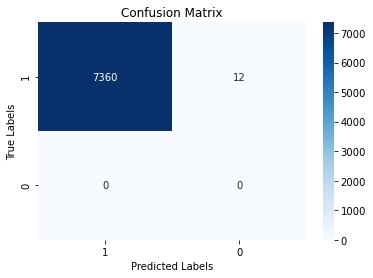

In [67]:
destination_folder = 'output_mixed_new'
#load model and send it to the GPU
#device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
#model = BERT().to(device)

#load the checkpoint
#load_checkpoint(destination_folder + '/model.pt', best_model)

#evaluate
y_pred = []
y_true = []
x_text = []
model.eval()
with torch.no_grad():
    for (text, labels), _ in tqdm(test_iter, desc='Testing examples'):
            labels = labels.type(torch.LongTensor)           
            labels = labels.to(device)
            text = text.type(torch.LongTensor)  
            text = text.to(device)
            output = model(text, labels)

            _, output = output
            x_text.extend(text.tolist())
            y_pred.extend(torch.argmax(output, 1).tolist())
            y_true.extend(labels.tolist())

print('Classification Report:')
print(classification_report(y_true, y_pred, labels=[1,0], digits=4))

cm = confusion_matrix(y_true, y_pred, labels=[1,0])
ax= plt.subplot()
sns.heatmap(cm, annot=True, ax = ax, cmap='Blues', fmt="d")

ax.set_title('Confusion Matrix')

ax.set_xlabel('Predicted Labels')
ax.set_ylabel('True Labels')

ax.xaxis.set_ticklabels(['1', '0'])
ax.yaxis.set_ticklabels(['1', '0'])

In [82]:
df_hdsa = pd.DataFrame(zip(x_text,y_pred,y_true), columns=['text', 'y_pred', 'y_true'])
df_hdsa = df_hdsa[(df_hdsa['y_pred'] == 0) & (df_hdsa['y_true'] == 1)]
df_hdsa['sentence'] = df_hdsa.text.map(lambda x: convert_ids_to_sentence(x, tokenizer))


(22, 4)

# Classification LSTM LM

In [6]:
tokenizer = BertTokenizer.from_pretrained('bert-base-uncased')

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Model parameter
MAX_SEQ_LEN = 128
PAD_INDEX = tokenizer.convert_tokens_to_ids(tokenizer.pad_token)
UNK_INDEX = tokenizer.convert_tokens_to_ids(tokenizer.unk_token)
source_folder = 'lm_lstm'

label_field = Field(sequential=False, use_vocab=False, batch_first=True, dtype=torch.float)
text_field = Field(use_vocab=False, tokenize=tokenizer.encode, lower=False, include_lengths=False, batch_first=True,
                   fix_length=MAX_SEQ_LEN, pad_token=PAD_INDEX, unk_token=UNK_INDEX)
fields = [('text', text_field), ('label', label_field)]

# TabularDataset

train, valid, test = TabularDataset.splits(path=source_folder, train='train_lstm_generated_new.csv', validation='valid_lstm_generated_new.csv',
                                           test='test_lstm_generated_new.csv', format='CSV', fields=fields, skip_header=True)

# Iterators

train_iter = BucketIterator(train, batch_size=64, sort_key=lambda x: len(x.text),
                            device=device, train=True, sort=True, sort_within_batch=True)
valid_iter = BucketIterator(valid, batch_size=64, sort_key=lambda x: len(x.text),
                            device=device, train=True, sort=True, sort_within_batch=True)
test_iter = Iterator(test, batch_size=64, device=device, train=False, shuffle=False, sort=False)

In [10]:

# Training Function
destination_folder = 'bert_lstm_lm'
def train(model,
          optimizer,
          criterion = nn.BCELoss(),
          train_loader = train_iter,
          valid_loader = valid_iter,
          num_epochs = 1,
          eval_every = len(train_iter) // 2,
          file_path = destination_folder,
          best_valid_loss = float("Inf")):
    
    # initialize running values
    running_loss = 0.0
    valid_running_loss = 0.0
    global_step = 0
    train_loss_list = []
    valid_loss_list = []
    global_steps_list = []

    # training loop
    model.train()
    for epoch in tqdm(range(num_epochs), desc='epochs'):
        for (text, labels), _ in tqdm(train_loader, desc='training examples'):
            labels = labels.type(torch.LongTensor)           
            labels = labels.to(device)
            text = text.type(torch.LongTensor)  
            text = text.to(device)
            output = model(text, labels)
            loss, _ = output

            optimizer.zero_grad()
            loss.backward()
            optimizer.step()

            # update running values
            running_loss += loss.item()
            global_step += 1

            # evaluation step
            if global_step % eval_every == 0:
                model.eval()
                with torch.no_grad():                    

                    # validation loop
                    for (text, labels), _ in valid_loader:
                        labels = labels.type(torch.LongTensor)           
                        labels = labels.to(device)
                        text = text.type(torch.LongTensor)  
                        text = text.to(device)
                        output = model(text, labels)
                        loss, _ = output
                        
                        valid_running_loss += loss.item()

                # evaluation
                average_train_loss = running_loss / eval_every
                average_valid_loss = valid_running_loss / len(valid_loader)
                train_loss_list.append(average_train_loss)
                valid_loss_list.append(average_valid_loss)
                global_steps_list.append(global_step)

                # resetting running values
                running_loss = 0.0                
                valid_running_loss = 0.0
                model.train()

                # print progress
                print('Epoch [{}/{}], Step [{}/{}], Train Loss: {:.4f}, Valid Loss: {:.4f}'
                      .format(epoch+1, num_epochs, global_step, num_epochs*len(train_loader),
                              average_train_loss, average_valid_loss))
                
                # checkpoint
                if best_valid_loss > average_valid_loss:
                    best_valid_loss = average_valid_loss
                    save_checkpoint(file_path + '/' + 'model.pt', model, best_valid_loss)
                    save_metrics(file_path + '/' + 'metrics.pt', train_loss_list, valid_loss_list, global_steps_list)
    
    save_metrics(file_path + '/' + 'metrics.pt', train_loss_list, valid_loss_list, global_steps_list)
    print('Finished Training!')

model = BERT().to(device)
optimizer = optim.Adam(model.parameters(), lr=2e-5)
load_checkpoint(destination_folder + '/model.pt', model)

train(model=model, optimizer=optimizer)

Some weights of the model checkpoint at bert-base-uncased were not used when initializing BertForSequenceClassification: ['cls.predictions.bias', 'cls.predictions.transform.dense.weight', 'cls.predictions.transform.dense.bias', 'cls.predictions.decoder.weight', 'cls.seq_relationship.weight', 'cls.seq_relationship.bias', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.transform.LayerNorm.bias']
- This IS expected if you are initializing BertForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPretraining model).
- This IS NOT expected if you are initializing BertForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at

Model loaded from <== bert_lstm_lm/model.pt


Epoch [1/1], Step [887/1775], Train Loss: 0.5532, Valid Loss: 0.5459
Model saved to ==> bert_lstm_lm/model.pt
Model saved to ==> bert_lstm_lm/metrics.pt
Epoch [1/1], Step [1774/1775], Train Loss: 0.3594, Valid Loss: 0.6507


Model saved to ==> bert_lstm_lm/metrics.pt
Finished Training!


Model loaded from <== bert_lstm_lm/metrics.pt


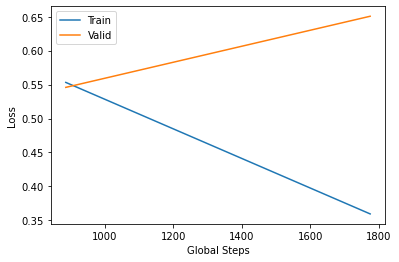

In [11]:
destination_folder = 'bert_lstm_lm'
train_loss_list, valid_loss_list, global_steps_list = load_metrics(destination_folder + '/metrics.pt')
plt.plot(global_steps_list, train_loss_list, label='Train')
plt.plot(global_steps_list, valid_loss_list, label='Valid')
plt.xlabel('Global Steps')
plt.ylabel('Loss')
plt.legend()
plt.show() 

Some weights of the model checkpoint at bert-base-uncased were not used when initializing BertForSequenceClassification: ['cls.predictions.bias', 'cls.predictions.transform.dense.weight', 'cls.predictions.transform.dense.bias', 'cls.predictions.decoder.weight', 'cls.seq_relationship.weight', 'cls.seq_relationship.bias', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.transform.LayerNorm.bias']
- This IS expected if you are initializing BertForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPretraining model).
- This IS NOT expected if you are initializing BertForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at


Classification Report:
              precision    recall  f1-score   support

           1     0.4366    0.0042    0.0083      7372
           0     0.4997    0.9946    0.6652      7372

    accuracy                         0.4994     14744
   macro avg     0.4682    0.4994    0.3368     14744
weighted avg     0.4682    0.4994    0.3368     14744



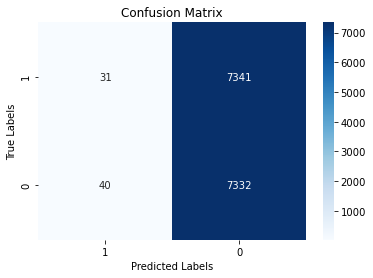

In [14]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = BERT().to(device)
#destination_folder = 'bert_lstm_lm'
#load the checkpoint
#load_checkpoint(destination_folder + '/model.pt', model)

x_text, y_pred, y_true = evaluate(model, test_iter)

In [15]:
tokenizer = AutoTokenizer.from_pretrained('bert-base-uncased')

# Model parameter
MAX_SEQ_LEN = 128
PAD_INDEX = tokenizer.convert_tokens_to_ids(tokenizer.pad_token)
UNK_INDEX = tokenizer.convert_tokens_to_ids(tokenizer.unk_token)
source_folder = 'sc_lstm'
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

label_field = Field(sequential=False, use_vocab=False, batch_first=True, dtype=torch.float)
text_field = Field(use_vocab=False, tokenize=tokenizer.encode, lower=False, include_lengths=False, batch_first=True,
                   fix_length=MAX_SEQ_LEN, pad_token=PAD_INDEX, unk_token=UNK_INDEX)
fields = [('text', text_field), ('label', label_field)]

# TabularDataset

test = TabularDataset.splits(path=source_folder, test='test_bert_sc_lstm_new.csv', format='CSV', fields=fields, skip_header=True)

# Iterators

test_iter = Iterator(test[0], batch_size=64, device=device, train=False, shuffle=False, sort=False)

Some weights of the model checkpoint at bert-base-uncased were not used when initializing BertForSequenceClassification: ['cls.predictions.bias', 'cls.predictions.transform.dense.weight', 'cls.predictions.transform.dense.bias', 'cls.predictions.decoder.weight', 'cls.seq_relationship.weight', 'cls.seq_relationship.bias', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.transform.LayerNorm.bias']
- This IS expected if you are initializing BertForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPretraining model).
- This IS NOT expected if you are initializing BertForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at

Model loaded from <== bert_lstm_lm/model.pt



Classification Report:
              precision    recall  f1-score   support

           1     0.0000    0.0000    0.0000         0
           0     1.0000    0.7899    0.8826      7372

    accuracy                         0.7899      7372
   macro avg     0.5000    0.3949    0.4413      7372
weighted avg     1.0000    0.7899    0.8826      7372



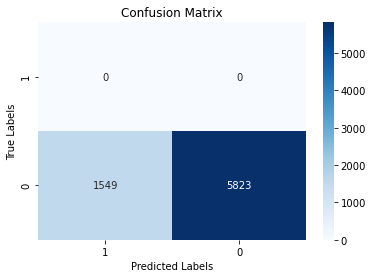

In [16]:
destination_folder = 'bert_lstm_lm'
model = BERT().to(device)
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

load_checkpoint(destination_folder + '/model.pt', model)
x_text, y_pred, y_true = evaluate(model, test_iter)